In [1]:
# Import packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
# Read the data
df = pd.read_csv('takehome_users.csv', encoding='ISO-8859–1')
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
# Convert to datetime
df['creation_time'] = pd.to_datetime(df['creation_time'])

In [4]:
# Read the other data
df2= pd.read_csv('takehome_user_engagement.csv')
df2.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
df2.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [6]:
df2['time_stamp'] = pd.to_datetime(df2['time_stamp'])

In [7]:
df2

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [8]:
# Aggregate 7 day rolling data for each timestamp
df_agg = df2.groupby('user_id').rolling('7D', on='time_stamp').visited.sum().reset_index()

In [9]:
# Assign adoption based on the aggregated data 
df_agg.visited = df_agg['visited'].astype('int')
df_agg['adopted_user'] = np.where(df_agg['visited'] >= 3, 1, 0)

In [10]:
df_agg

,user_id,time_stamp,visited,adopted_user
0,1,2014-04-22 03:53:30,1,0
1,2,2013-11-15 03:45:04,1,0
2,2,2013-11-29 03:45:04,1,0
3,2,2013-12-09 03:45:04,1,0
4,2,2013-12-25 03:45:04,1,0
...,...,...,...,...
207912,11996,2013-09-06 06:14:15,1,0
207913,11997,2013-01-15 18:28:37,1,0
207914,11998,2014-04-27 12:45:16,1,0
207915,11999,2012-06-02 11:55:59,1,0


In [11]:
# An user is considered adopted_user if the user is identified as an adopted user in any of the aggregated data
df_adopted = df_agg.groupby('user_id').adopted_user.sum().reset_index(name ='Adopted')

In [12]:
df_adopted

,user_id,Adopted
0,1,0
1,2,2
2,3,0
3,4,0
4,5,0
...,...,...
8818,11996,0
8819,11997,0
8820,11998,0
8821,11999,0


In [13]:
# Convert the frequent adopted_user to boolean
df_adopted['Adopted'] = np.where(df_adopted['Adopted'] >= 1, 1, 0)
df_adopted.head()

,user_id,Adopted
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [14]:
# Join feature and target
df_joined = df.join(df_adopted.set_index('user_id'), on ='object_id')

In [15]:
df_joined

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,0.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,0.0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,0.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,0.0


In [16]:
df_joined.Adopted.value_counts(dropna=False)

0.0    7221
NaN    3177
1.0    1602
Name: Adopted, dtype: int64

In [17]:
# Missing adopted user are non-adopted user 
df_joined['Adopted'].fillna(0, inplace=True)
df_joined.Adopted.value_counts(dropna=False)

0.0    10398
1.0     1602
Name: Adopted, dtype: int64

In [18]:
df_joined.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
Adopted                          0
dtype: int64

In [19]:
# if an user is not invited by another user the field is usually na
df_joined.invited_by_user_id.fillna(0, inplace=True)

In [20]:
df_joined.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id               0
Adopted                          0
dtype: int64

In [21]:
# Making sure that there is no accidental non-boolean invited by user value
df_joined.invited_by_user_id = df_joined.invited_by_user_id.apply(lambda x: 1 if x != 0 else x).astype('int')
df_joined
                                                            

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,1,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,1,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,1,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,1,0.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,0,0.0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,1,0.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,0,0.0


In [22]:
# Drop the object id, email, and name
df_joined = df_joined.drop(['object_id', 'email', 'name'], axis=1)
df_joined['creation_time'] = df_joined['creation_time'].astype('int')

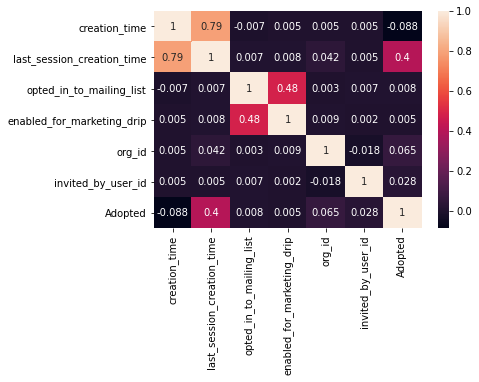

In [23]:
sns.heatmap(round(df_joined.corr(), 3), annot=True)
plt.show()

It seems like creation time and last_session_creation_time has the high correlation (also some data are missing for last_session_creation_time).

In [24]:
# Split data into seen and unseen
data, data_unseen = train_test_split(df_joined, train_size=0.8, random_state=42)
print(f"There are {data_unseen.shape[0]} samples for Unseen Data.")

There are 2400 samples for Unseen Data.


In [25]:
# Setup the pycaret classifier environment
clf_setup = setup(data = df_joined, 
                  target = 'Adopted', 
                  session_id=123,
                  normalize = True, 
                  transformation = True, 
                  ignore_low_variance = True,
                  fix_imbalance=True,
                  remove_multicollinearity = True, 
                  multicollinearity_threshold = 0.9,
                  categorical_features=['creation_source'],
                  log_experiment = True, 
                  experiment_name = 'relax_inc',
                  train_size=0.75)

,Description,Value
0,session_id,123
1,Target,Adopted
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(12000, 8)"
5,Missing Values,True
6,Numeric Features,3
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [26]:
# Get top 5 models
top_5_model = compare_models(fold=5,
                           sort="AUC",
                           n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9684,0.9899,0.9157,0.8536,0.8834,0.8652,0.8660,11.8580
gbc,Gradient Boosting Classifier,0.9690,0.9891,0.9030,0.8657,0.8838,0.8659,0.8663,0.3400
lightgbm,Light Gradient Boosting Machine,0.9680,0.9888,0.9209,0.8477,0.8826,0.8641,0.8652,0.1640
xgboost,Extreme Gradient Boosting,0.9677,0.9884,0.9115,0.8517,0.8804,0.8617,0.8625,0.5340
rf,Random Forest Classifier,0.9619,0.9788,0.8443,0.8617,0.8525,0.8306,0.8309,0.2180
et,Extra Trees Classifier,0.9617,0.9730,0.8162,0.8816,0.8474,0.8255,0.8265,0.1520
ada,Ada Boost Classifier,0.9671,0.9726,0.8545,0.8895,0.8715,0.8527,0.8530,0.1280
dt,Decision Tree Classifier,0.9589,0.9355,0.9038,0.8064,0.8519,0.8281,0.8302,0.0220
lr,Logistic Regression,0.8846,0.9283,0.8230,0.5385,0.6507,0.5852,0.6043,0.7260
knn,K Neighbors Classifier,0.9403,0.9227,0.8281,0.7445,0.7838,0.7493,0.7509,0.4580


In [27]:
print('Top 5 models are:')
top_5_model

Top 5 models are:


 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_iter_no_change=None, presort='deprecated',
                            random_state=123, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False),
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31

As expected, extreme gradient boosting based methods are the top performers

In [28]:
# Tune the best model
tuned_model = tune_model(estimator=top_5_model[0], fold=5,
                         optimize="AUC", choose_better=True,
                         verbose=False)

In [29]:
# Best parameters are:
plot_model(tuned_model, plot="parameter")

,Parameters
nan_mode,Min
eval_metric,Logloss
iterations,250
sampling_frequency,PerTree
leaf_estimation_method,Newton
grow_policy,SymmetricTree
penalties_coefficient,1
boosting_type,Plain
model_shrink_mode,Constant
feature_border_type,GreedyLogSum


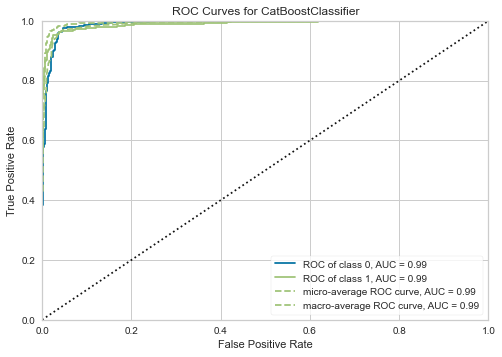

In [30]:
# Plot the roc auc curve
plot_model(tuned_model, plot="auc")

In terms of roc_auc_score, the tuned model is phenomenal, but since our data is imbalanced, we need to also look at the precision-recall curve.

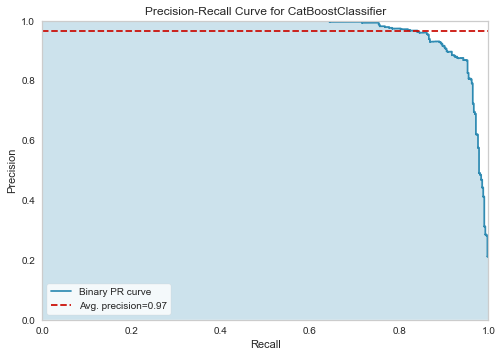

In [31]:
# Precision recall curve
plot_model(tuned_model, plot="pr")

Our model's performance is great and it can tackle the data imbalance quite magnificently.

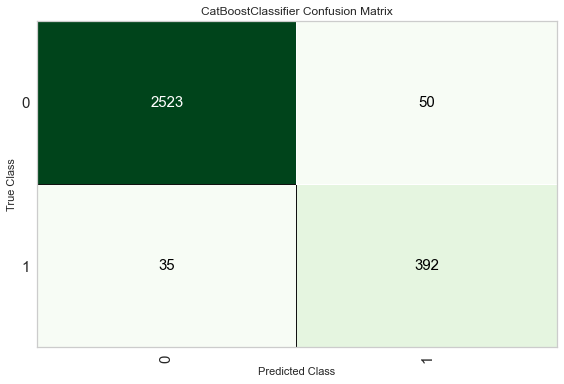

In [32]:
# Plot the confusion matrix
plot_model(tuned_model, plot="confusion_matrix")

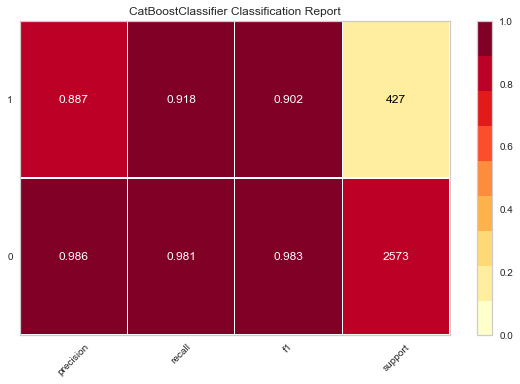

In [33]:
# Plot individual class report which is crucial to judge how the model is performing for both the majority and minority class
plot_model(tuned_model, plot="class_report")

As expected, the model performance for minority class is not as impressive as the performance of the majority class. However, it can be considered a really good production label performance. In order to not lose potentially important user, we can be conservative and try to tune the model to decrese false negative in the expense of false positive as it won't affect the custom invitation budget too much. 

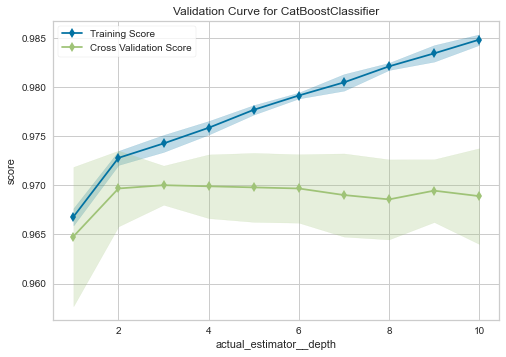

In [34]:
# score as a function of estimator depth 
plot_model(tuned_model, plot="vc")

In [38]:
# All these model performance parameters are exposed with this sleek pycaret gui
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [39]:
# Predictive performance of the tuned model
predict_model(tuned_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.9717,0.9899,0.9180,0.8869,0.9022,0.8856,0.8858


,creation_time,last_session_creation_time,org_id,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,opted_in_to_mailing_list_0,enabled_for_marketing_drip_0,invited_by_user_id_0,Adopted,Label,Score
0,0.773806,-0.132722,-1.035197,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.9997
1,-0.499064,-0.856007,-0.732086,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.9678
2,0.724257,0.462658,-0.484089,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.9440
3,-1.321676,-1.651610,0.260411,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.9742
4,-0.752195,-1.105747,-1.358586,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.9865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,-1.290172,-1.621931,0.788382,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.9566
2996,-0.927356,1.544363,-0.000085,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0000
2997,-0.100992,-0.132722,-0.518510,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.9743
2998,0.987207,-0.132722,-0.623798,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.9998


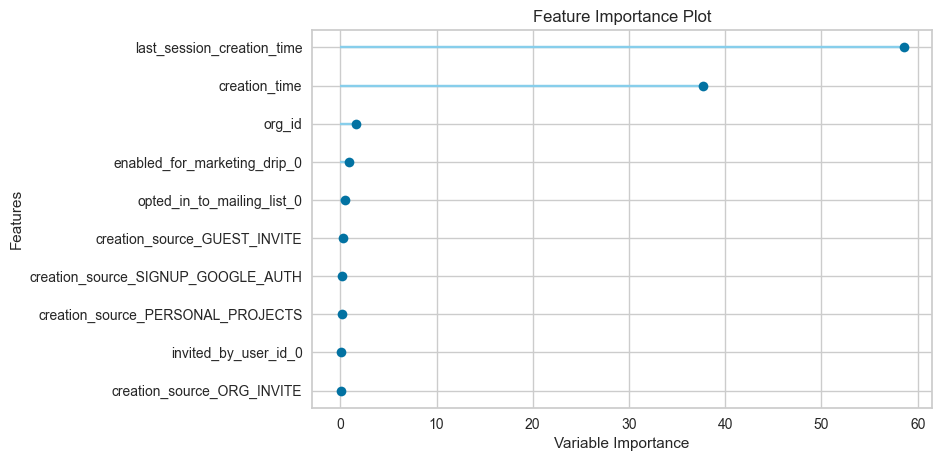

In [41]:
# Feature importance plot
plot_model(tuned_model, plot='feature')

Last session creation time and creation time both are very important features. Most likely if they are not the same, the user is likely an adopted user. If they are same, the user creted the account and then never logged into the account again.

In [42]:
# Save the tuned model as final model
final_model = finalize_model(tuned_model)

In [43]:
# Calculate scores with Test/Unseen labeled data
def test_score_report(data_unseen, predict_unseen):
    accuracy = accuracy_score(data_unseen, predict_unseen)
    roc_auc = roc_auc_score(data_unseen, predict_unseen)
    precision = precision_score(data_unseen, predict_unseen)
    recall = recall_score(data_unseen, predict_unseen)
    f1 = f1_score(data_unseen, predict_unseen)

    df_unseen = pd.DataFrame({
        "Accuracy" : [accuracy],
        "AUC" : [roc_auc],
        "Recall" : [recall],
        "Precision" : [precision],
        "F1 Score" : [f1]
    })
    return df_unseen
# Confusion Matrix
def conf_mat(data_unseen, predict_unseen):
    unique_label = data_unseen.unique()
    cmtx = pd.DataFrame(
        confusion_matrix(data_unseen,
                         predict_unseen,
                         labels=unique_label), 
        index=['{:}'.format(x) for x in unique_label], 
        columns=['{:}'.format(x) for x in unique_label]
    )
    ax = sns.heatmap(cmtx, annot=True, fmt="d", cmap="YlGnBu")
    ax.set_ylabel('Predicted')
    ax.set_xlabel('Target')
    ax.set_title("Predict Unseen Confusion Matrix", size=14);


 Accuracy      AUC   Recall  Precision  F1 Score
 0.975833 0.969213 0.960123   0.874302  0.915205


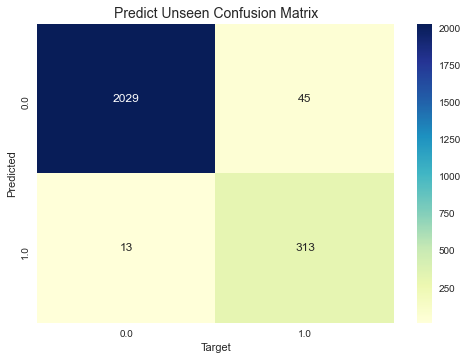

In [44]:
predict_unseen = predict_model(final_model, data=data_unseen)
score_unseen = test_score_report(data_unseen['Adopted'], predict_unseen['Label'].astype('float'))
print(score_unseen.to_string(index=False))
conf_mat(data_unseen['Adopted'], predict_unseen['Label'].astype('float'))

Overall, the performance of the CatBoost classifier is great and it can be deployed onto production for making efficient prediction of user adoption.